Let's now do an inverse problem to recover the Y field given a pressure field. I have a trained DeepONet and a synthetic dataset of a Y field distribution i'm interested in.

In [2]:
from pathlib import Path
import sys
from typing import Callable


import jax
import jax.numpy as jnp
import numpy as np
import equinox as eqx

import optax
import h5py


import matplotlib.pyplot as plt

# Loading artificial dataset and auxiliary data.

Let's start by loading the necessary data! First let's load the KL transform matrix $T$. And the reference fields.

In [5]:
TESTING_DATA_FILE = Path("../../outputs/poisson_pressure_simulations_test.h5")

with h5py.File(TESTING_DATA_FILE, "r") as f:
    print(f.keys())
    X = jnp.array(f["positions"])
    T = jnp.array(f["kl_transform_matrice"])


P_ref_file = Path("../../raw_data/pressure_ref.dat")
Y_ref_file = Path("../../raw_data/YS_ref.dat")

P_ref = jnp.array(np.loadtxt(P_ref_file))
Y_ref = jnp.array(np.loadtxt(Y_ref_file))

pos  = [255, 755, 1255, 1755, 2255,  265,  765, 1265, 1765, 2265,  275, 775,
        1275, 1775, 2275,  285,  785, 1285, 1785, 2285,  295,  795, 1295, 1795, 2295]

X_ref = X[pos, :]

<KeysViewHDF5 ['Y_fields', 'kl_coefficients', 'kl_transform_matrice', 'positions', 'pressure_fields', 'sensor_position_indexes']>


In [12]:
print(T[:, :10])

[[ 1.01446345e-01  4.02250281e-03 -2.31745586e-01 ...  3.95415068e-01
  -3.51656865e-07  2.01688349e-01]
 [ 1.11081734e-01  7.53286853e-03 -2.50517964e-01 ...  4.12686467e-01
   1.46855833e-02  2.06158802e-01]
 [ 1.20943271e-01  1.17963860e-02 -2.69036561e-01 ...  4.26527172e-01
   3.16350050e-02  2.08815292e-01]
 ...
 [ 1.20942838e-01 -1.17957741e-02  2.69034296e-01 ... -4.26531404e-01
  -3.16349790e-02 -2.08819181e-01]
 [ 1.11082278e-01 -7.53253605e-03  2.50517428e-01 ... -4.12689239e-01
  -1.46861123e-02 -2.06161603e-01]
 [ 1.01446569e-01 -4.02251864e-03  2.31746182e-01 ... -3.95415664e-01
  -1.34796974e-08 -2.01689646e-01]]


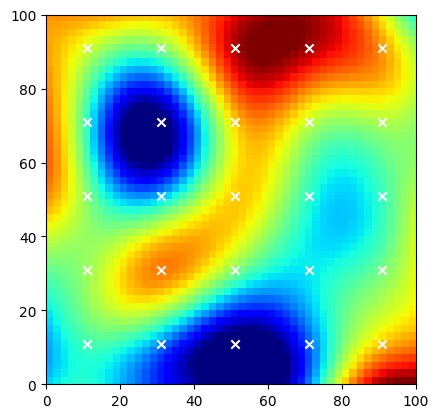

In [3]:
plt.imshow(Y_ref.reshape(50, 50), cmap="jet", origin="lower", vmin=-2, vmax=2, extent=[0, 100, 0, 100])
plt.scatter(*X_ref.T, marker="x", c="w")

The reference data is this one. Now i need to also load in the sets of KL transform coefficients that i've used to define in which intervals the DeepONet was trained on!

In [4]:
DATA_FILE = Path("../../outputs/poisson_pressure_simulations.h5")

with h5py.File(DATA_FILE, "r") as f:
    print(f.keys())
    theta = jnp.array(f["kl_coefficients"])

<KeysViewHDF5 ['Y_fields', 'kl_coefficients', 'kl_transform_matrice', 'positions', 'pressure_fields', 'sensor_position_indexes']>


Let's build a function that can create random numbers inside this range to be used as initial guess on our procedure.

In [5]:
min_, max_ = theta.min(axis=0), theta.max(axis=0)

min_.shape, max_.shape

((24,), (24,))

In [13]:
def generate_initial_guess_normal(key):

    guesses = []
    for a, b in zip(min_, max_):
        key, key_k = jax.random.split(key)
        guess = jax.random.normal(key_k)*(a-b)/6 + (a+b)/2
        guesses.append(guess)
        
    return jnp.array(guesses)


def generate_initial_guess_uniform(key):

    guesses = []
    for a, b in zip(min_, max_):
        key, key_k = jax.random.split(key)
        guess = jax.random.uniform(key_k, minval=a, maxval=b)
        guesses.append(guess)
    
    return jnp.array(guesses)

# Defining and loading model

In [7]:
class DeepOnet(eqx.Module):
    branch_net: eqx.nn.MLP
    trunk_net: eqx.nn.MLP
    bias: jax.Array

    def __init__(
        self, 
        in_branch: int,
        in_trunk: int,
        width: int,
        depth: int,
        interact: int,
        activation: Callable,
        *,
        key
    ):
        """
        Simplified deeponet using twin hidden architectures
        """

        b_key, t_key = jax.random.split(key)

        self.branch_net = eqx.nn.MLP(
            in_branch,
            interact,
            width,
            depth,
            activation,
            key=b_key
        )

        self.trunk_net = eqx.nn.MLP(
            in_trunk,
            interact,
            width,
            depth,
            activation,
            final_activation=activation,
            key=b_key
        )

        self.bias = jnp.zeros((1,))

    
    def __call__(self, x_branch, x_trunk):
        """
        x_branch.shape = (in_size_branch,)
        x_trunk.shape = (1,)

        return shape: "scalar"
        """

        branch_out = self.branch_net(x_branch)
        trunk_out = self.trunk_net(x_trunk)

        inner_product = jnp.sum(branch_out*trunk_out, keepdims=True)

        return (inner_product + self.bias)[0]
        


In [20]:
key = jax.random.key(1325)
key = jax.random.key(6757)

deeponet = DeepOnet(
    24,
    2,
    256,
    5,
    128,
    activation=jax.nn.relu,
    key=key
)

deeponet = eqx.tree_deserialise_leaves("../../outputs/fivespot_deeponet_best.eqx", deeponet)

In [21]:
# key = jax.random.key(2432)
args = generate_initial_guess_normal(key)
losses = []

In [22]:
lr = 0.01

def loss_fn(args):
    
    out = jax.vmap(deeponet, in_axes=(None, 0))(args, X_ref)
    delta = (out - P_ref)**2

    return jnp.mean(delta)

@eqx.filter_jit
def update(args, lr=lr):
    loss, grad = eqx.filter_value_and_grad(loss_fn)(args)

    losses.append(loss)
    args -= lr*grad
    return loss, args


for it in range(5_000):

    loss, args = update(args)

    
    if it % 10 == 0:
        print(f"{it = } | {loss = }")


it = 0 | loss = Array(1.2073666, dtype=float32)
it = 10 | loss = Array(1.0151893, dtype=float32)
it = 20 | loss = Array(0.96344763, dtype=float32)
it = 30 | loss = Array(0.93639785, dtype=float32)
it = 40 | loss = Array(0.9127645, dtype=float32)
it = 50 | loss = Array(0.89055336, dtype=float32)
it = 60 | loss = Array(0.86898315, dtype=float32)
it = 70 | loss = Array(0.8483527, dtype=float32)
it = 80 | loss = Array(0.82863426, dtype=float32)
it = 90 | loss = Array(0.81050617, dtype=float32)
it = 100 | loss = Array(0.7950511, dtype=float32)
it = 110 | loss = Array(0.7802315, dtype=float32)
it = 120 | loss = Array(0.76302695, dtype=float32)
it = 130 | loss = Array(0.7446759, dtype=float32)
it = 140 | loss = Array(0.72737926, dtype=float32)
it = 150 | loss = Array(0.7110798, dtype=float32)
it = 160 | loss = Array(0.69565403, dtype=float32)
it = 170 | loss = Array(0.6808336, dtype=float32)
it = 180 | loss = Array(0.6663473, dtype=float32)
it = 190 | loss = Array(0.65276474, dtype=float32)
i

[Text(0.5, 1.0, 'Recovered'), Text(0.5, 0, 'X'), None]

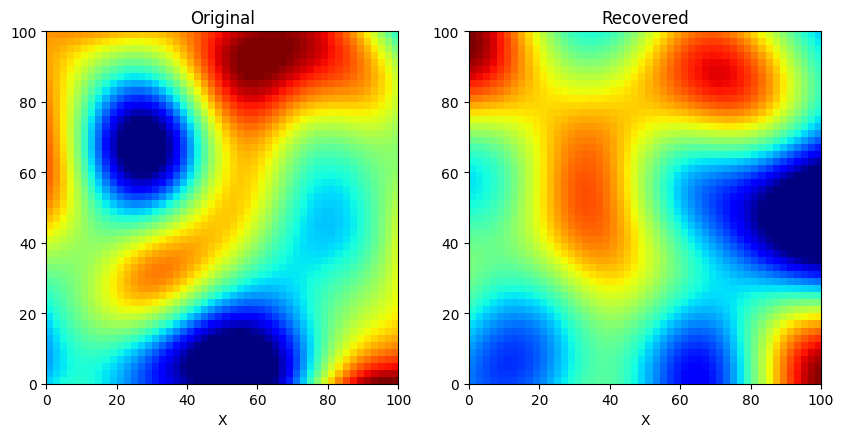

In [23]:
Y_recovered = (T@(args.reshape(-1, 1))).ravel().reshape(50, 50)

fig, [ax1, ax2] = plt.subplots(ncols=2, figsize=(10, 5))

ax1.imshow(Y_ref.reshape(50, 50), cmap="jet", origin="lower", vmin=-2, vmax=2, extent=[0, 100, 0, 100])
ax1.set(title="Original", xlabel="X")
# ax1.scatter(*X_ref.T, marker="o", c="w", edgecolors="k")

ax2.imshow(Y_recovered, origin="lower", cmap="jet", vmin=-2, vmax=2, extent=[0, 100, 0, 100])
ax2.set(title="Recovered", xlabel="X", label="Y")
# ax2.scatter(*X_ref.T, marker="o", c="w", edgecolors="k")
